In [1]:
# import packages

import numpy as np
import pandas as pd
import pydicom
import os
from os import makedirs
from os.path import exists
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from scipy import ndimage

from math import ceil, floor, log
import cv2

import tensorflow as tf

from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, Concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, PReLU
import math
import numpy as np
import os
import pickle
import time
from scipy import misc

tf.test.is_gpu_available()

True

In [3]:
# create the table
# import the data path (modify here to change to your image path)
train_path = '/home/.../motion/new/'
val_path = '/home/.../motion/new_val/'

train_list = os.listdir(train_path)
val_list = os.listdir(val_path)

In [4]:
dict = {'train': train_list}
df_train = pd.DataFrame(dict)  
    
# saving the dataframe  
# df.to_csv('train.csv', index = False)  

dict = {'val': val_list}
df_val = pd.DataFrame(dict)  
df_val.head(10)
# saving the dataframe  
# df.to_csv('val.csv', index = False)

,val
0,106P_trans_sinu_1_10.png
1,103I_interl_mot_centric.png
2,106P_trans_hori_ave.png
3,103I_lin_mot_centric.png
4,109P_trans_sinu_ave.png
5,103I_rot_mix.png
6,106P_trans_sinu_ave.png
7,103I_sin_mot_centric.png
8,109P_trans_vert_1_10.png
9,103P_rot_1_2.png


In [1]:
df_train = df_train.set_index(['train'])
df_val = df_val.set_index(['val'])
df_val.index

In [6]:
# the architecture of the generator
# model
import copy
n_f = 32
def conv_block(x, n_f, strides_x, strides_y):
    x2 = Conv2D(filters=n_f, kernel_size=(3,3), strides=(strides_x, strides_y), kernel_initializer='he_normal', padding='same')(x)
    x2 = BatchNormalization(axis=-1, epsilon=1e-3)(x2)
    x2 = LeakyReLU(alpha=0.3)(x2)
    return x2
#####U-net block####
def m_block(x):
    x2 = conv_block(x, n_f, 1, 1)
    x2 = conv_block(x2, n_f, 1, 1)
#     x2 = Dropout(0.3)(x2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    
    x3 = conv_block(pool2, n_f, 1, 1)
    x3 = conv_block(x3, n_f, 1, 1)
#     x3 = Dropout(0.3)(x3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x3)
    
    x4 = conv_block(pool3, n_f, 1, 1)
    x4 = conv_block(x4, n_f, 1, 1)
#     x4 = Dropout(0.3)(x4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(x4)

    x5 = conv_block(pool4, n_f, 1, 1)
    x5 = conv_block(x5, n_f, 1, 1)
#     x5 = Dropout(0.3)(x5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(x5)
    
    x6 = conv_block(pool5, n_f, 1, 1)
    x6 = conv_block(x6, n_f, 1, 1)
#     x6 = Dropout(0.3)(x6)
    
    up7 = UpSampling2D(size = (2,2))(x6)
    up7 = conv_block(up7, n_f, 1, 1)
    merge7 = Concatenate(axis=-1)([x5,up7])
    x7 = conv_block(merge7, n_f, 1, 1)
    x7 = conv_block(x7, n_f, 1, 1)
#     x7 = Dropout(0.3)(x7)
    
    up8 = UpSampling2D(size = (2,2))(x7)
    up8 = conv_block(up8, n_f, 1, 1)
    merge8 = Concatenate(axis=-1)([x4,up8])
    x8 = conv_block(merge8, n_f, 1, 1)
    x8 = conv_block(x8, n_f, 1, 1)
#     x8 = Dropout(0.3)(x8)

    up9 = UpSampling2D(size = (2,2))(x8)
    up9 = conv_block(up9, n_f, 1, 1)
    merge9 = Concatenate(axis=-1)([x3,up9])
    x9 = conv_block(merge9, n_f, 1, 1)
    x9 = conv_block(x9, n_f, 1, 1)
#     x9 = Dropout(0.3)(x9)
    
    up10 = UpSampling2D(size = (2,2))(x9)
    up10 = conv_block(up10, n_f, 1, 1)
    merge10 = Concatenate(axis=-1)([x2,up10])
    x10 = conv_block(merge10, n_f, 1, 1)
    x10 = conv_block(x10, n_f, 1, 1)
#     x10 = Dropout(0.3)(x10)
    return x10
#####res block##########
def res_block(x_in,n_layer):
    for i in range(n_layer):
        x_r = m_block(x_in)
    x_r_block = tensorflow.keras.layers.Add()([x_in, x_r])
    x_r_block = LeakyReLU(alpha=0.3)(x_r_block)
    return x_r_block
#####dense block#########
def dense_block(x, n_layer):
    list_feat = [x]
#     x2 = m_block(x)
#     list_feat.append(x2)
#     concat2 = Concatenate(axis=-1)(list_feat)
    
#     x3 = m_block(concat2)
#     list_feat.append(x3)
#     concat3 = Concatenate(axis=-1)(list_feat)
    
#     return concat3|
    for i in range(n_layer):
        x = m_block(x)
        list_feat.append(x)
        x = Concatenate(axis=-1)(copy.copy(list_feat))
#         print(list_feat)
    return x

In [7]:
inpt = Input(shape=(512,512,1))
######dense net######
x_b = dense_block(inpt, 3)

x_b = conv_block(x_b, 1, 1, 1)
# print(x_b)
x_out = tensorflow.keras.layers.Subtract()([inpt, x_b])   # input - noise
# print(x_out)
generator = Model(inputs=inpt, outputs=x_out)


generator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
# discriminator network
n_f = 32
def conv_block_dis(x, n_f_dis, strides_x, strides_y):
    x2 = Conv2D(filters=n_f, kernel_size=(3,3), strides=(strides_x, strides_y), kernel_initializer='he_normal', padding='same')(x)
    x2 = BatchNormalization(axis=-1, epsilon=1e-3)(x2)
    x2 = LeakyReLU(0.3)(x2)
    return x2

image_input = tensorflow.keras.layers.Input(shape=(512, 512, 1))
x = conv_block_dis(image_input, n_f, 4, 4)

x = conv_block_dis(x, n_f, 4, 4)

x = conv_block_dis(x, n_f, 4, 4)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dropout(0.3)(x)
x = tensorflow.keras.layers.Dense(1)(x)

discriminator = Model(inputs=image_input, outputs=x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_67 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_68 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 32, 32, 32)        0   

In [10]:
# build the architecture of the discrminator 
# discriminator_network.trainable=False

g_output = generator(inpt)
d_output = discriminator(g_output)

gan_model = tensorflow.keras.models.Model(inpt, d_output)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
model (Model)                (None, 512, 512, 1)       731150    
_________________________________________________________________
model_1 (Model)              (None, 1)                 21249     
Total params: 752,399
Trainable params: 747,981
Non-trainable params: 4,418
_________________________________________________________________


In [11]:
# import the pre-trained weights in stage-I 
# You can find the weights in "GAN_MotionRemoval/model/model_denoising2.hdf5"
generator.load_weights('/home/.../motion/model/model_denoising2.hdf5', by_name = True) 

In [13]:
from tensorflow import keras
def load(image_file):
    
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=1)

    w = tf.shape(image)[1]
    
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
#     tf.print(tf.shape(input_image)) #[512 512 1]
#     tf.print(w) # 512

    return input_image, real_image

# inp, re = load('/home/yunan/motion/full_val/z_1_49.png')

In [14]:
# plt.figure()
# plt.imshow(inp/255.0)
# plt.figure()
# plt.imshow(re/255.0)

In [15]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [16]:
# Train
BUFFER_SIZE = 200
BATCH_SIZE = 2

PATH = '/home/yunan/motion/'
train_dataset = tf.data.Dataset.list_files(PATH+'new/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Test without shuffle in each iteration
test_dataset = tf.data.Dataset.list_files(PATH+'new_val/*.png', shuffle = False)
test_dataset = test_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Test with shuffle in each iteration
test_dataset_shuffle = tf.data.Dataset.list_files(PATH+'new_val/*.png')
# test_dataset_shuffle = test_dataset.shuffle(BUFFER_SIZE)
test_dataset_shuffle = test_dataset_shuffle.map(load_image_test)
test_dataset_shuffle = test_dataset_shuffle.batch(BATCH_SIZE)

In [17]:
# tf.keras.utils.plot_model(gan_model, show_shapes=True, dpi=64)

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
lossModel = VGG16(include_top=False, weights= 'imagenet', input_shape=(512,512,3))
lossModel.trainable = False
for l in lossModel.layers:
    l.trainable = False

def Perceptual_model_15(lossModel, VGG_in):
    #select layers
    selectedLayers = 15 #for instance
    selectedOutputs = lossModel.layers[selectedLayers].output
    perModel = Model(lossModel.inputs,selectedOutputs)
    lossModelOutputs = perModel(VGG_in)
    return lossModelOutputs

def Perceptual_model_16(lossModel, VGG_in):
    #select layers
    selectedLayers = 16 #for instance
    selectedOutputs = lossModel.layers[selectedLayers].output
    perModel = Model(lossModel.inputs,selectedOutputs)
    lossModelOutputs = perModel(VGG_in)
    return lossModelOutputs

def Perceptual_model_17(lossModel, VGG_in):
    #select layers
    selectedLayers = 17 #for instance
    selectedOutputs = lossModel.layers[selectedLayers].output
    perModel = Model(lossModel.inputs,selectedOutputs)
    lossModelOutputs = perModel(VGG_in)
    return lossModelOutputs

58892288/58889256 [==============================] - 1s 0us/step


In [19]:
LAMBDA1 = 0.008
LAMBDA2 = 0.01
LAMBDA3 = 0.006
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    gen_output_scale = (gen_output + 1.0) * 0.5 * 255.0
    target_scale = (target + 1.0) * 0.5 * 255.0
    
    vgg_input = tf.concat([gen_output_scale, gen_output_scale, gen_output_scale], -1)
    target_vgg_input = tf.concat([target_scale,target_scale,target_scale], -1)
    
    vgg_input = tf.keras.applications.vgg16.preprocess_input(vgg_input)
    target_vgg_input = tf.keras.applications.vgg16.preprocess_input(target_vgg_input)
    
    
    percep_loss_15 = tf.keras.losses.MSE(Perceptual_model_15(lossModel, target_vgg_input), Perceptual_model_15(lossModel, vgg_input))
    percep_loss_15 = K.mean(percep_loss_15, axis = [0,1,2])
    percep_loss_16 = tf.keras.losses.MSE(Perceptual_model_16(lossModel, target_vgg_input), Perceptual_model_16(lossModel, vgg_input))
    percep_loss_16 = K.mean(percep_loss_16, axis = [0,1,2])
    percep_loss_17 = tf.keras.losses.MSE(Perceptual_model_17(lossModel, target_vgg_input), Perceptual_model_17(lossModel, vgg_input))
    percep_loss_17 = K.mean(percep_loss_17, axis = [0,1,2])
    percep_loss = percep_loss_15 + percep_loss_16 + percep_loss_17
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = (LAMBDA1 * gan_loss) + (LAMBDA2 * l1_loss) + (LAMBDA3 * percep_loss)

    return total_gen_loss, LAMBDA1 * gan_loss, LAMBDA2 * l1_loss, LAMBDA3 * percep_loss 

In [20]:
# Cell 9
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [21]:
# Cell 10
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)  # the only thing changed here. 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

checkpoint_dir = './model/new_model_new_data_v8/'
if not exists(checkpoint_dir):
    makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

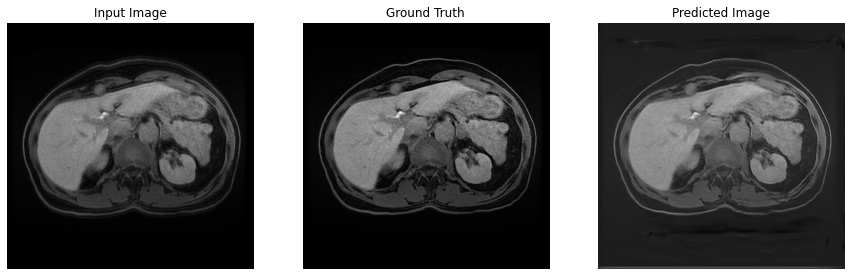

Mean Squared Error: 0.005774560384452343


In [23]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i][:,:,0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

    mse = (np.square(tar - prediction)).mean()
    print (f'Mean Squared Error: {mse}')

for example_input, example_target in test_dataset.take(1):
#     tf.print(tf.shape(example_input)) # [2 512 512 1]
#     tf.print(tf.shape(example_target))# [2 512 512 1]
    generate_images(generator, example_input, example_target)
# for example_input, example_target in test_dataset_skip1.take(1):
# #     tf.print(tf.shape(example_input)) # [2 512 512 1]
# #     tf.print(tf.shape(example_target))# [2 512 512 1]
#     generate_images(generator, example_input, example_target)

In [24]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# @tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)   # concatenate 

        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss, per_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    if epoch%5 == 0:
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
    else:
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
        tf.summary.scalar('per_loss', per_loss, step=epoch)
    return gen_total_loss,gen_gan_loss, gen_l1_loss, per_loss, disc_loss



In [25]:
# @tf.function
def val_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=False)   # concatenate 

        disc_real_output = discriminator(target, training=False)
        disc_generated_output = discriminator(gen_output, training=False)

        gen_total_loss, gen_gan_loss, gen_l1_loss, per_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss_val', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss_val', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss_val', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss_val', disc_loss, step=epoch)
        tf.summary.scalar('per_loss_val', per_loss, step=epoch)
    return gen_total_loss,gen_gan_loss, gen_l1_loss, per_loss, disc_loss


# Train

In [26]:
# Training Loop
#   - Iterates over the number of epochs.
#   - On each epoch it clears the display, and runs `generate_images` to show it's progress.
#   - On each epoch it iterates over the training dataset, printing a '.' for each example.
#   - It saves a checkpoint every 20 epochs.
from IPython import display
def fit(train_ds, epochs, test_ds):
    # stopping at the minimum val loss
    stopping_loss = 1000
    patience_count= 0
    patience_max = 5
#     picked_example = test_ds.take(1)
#     test_ds = test_ds.skip(1)
    for epoch in range(epochs):
        start = time.time()
#         display.clear_output(wait=True)
#         # the same datapoint
        for example_input, example_target in test_dataset.take(1):
            generate_images(generator, example_input, example_target)
        # different data point
        for example_input, example_target in test_dataset_shuffle.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        gen_total_loss_average = 0
        gen_gan_loss_average = 0
        gen_l1_loss_average = 0
        disc_loss_average = 0
        per_loss_average = 0
        for n, (input_image, target) in train_ds.enumerate():
            gen_total_loss,gen_gan_loss, gen_l1_loss, per_loss, disc_loss = train_step(input_image, target, epoch)
            gen_total_loss_average += gen_total_loss
            gen_gan_loss_average += gen_gan_loss
            gen_l1_loss_average += gen_l1_loss
            disc_loss_average += disc_loss
            per_loss_average += per_loss
#             if n == 2:
#                 break
        gen_total_loss_average /= tf.dtypes.cast(n+1, tf.float32)
        gen_gan_loss_average /= tf.dtypes.cast(n+1, tf.float32)
        gen_l1_loss_average /= tf.dtypes.cast(n+1, tf.float32)
        disc_loss_average /= tf.dtypes.cast(n+1, tf.float32)
        per_loss_average /= tf.dtypes.cast(n+1, tf.float32)
        print("Epoch:%.0f, gen_total_loss:%.5f, gen_gan_loss:%.5f, gen_l1_loss:%.5f, per_loss:%.5f, disc_loss:%.5f "%(epoch,gen_total_loss_average,gen_gan_loss_average, gen_l1_loss_average, per_loss_average, disc_loss_average))
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
        
        # val
        gen_total_loss_val_average = 0
        gen_gan_loss_val_average = 0
        gen_l1_loss_val_average = 0
        disc_loss_val_average = 0
        per_loss_val_average = 0

        for n, (input_image, target) in test_ds.enumerate():
            gen_total_loss_val,gen_gan_loss_val, gen_l1_loss_val, per_loss_val, disc_loss_val = val_step(input_image, target, epoch)
            gen_total_loss_val_average += gen_total_loss_val
            gen_gan_loss_val_average += gen_gan_loss_val
            gen_l1_loss_val_average += gen_l1_loss_val
            disc_loss_val_average += disc_loss_val
            per_loss_val_average += per_loss_val
#             if n == 2:
#                 break
        gen_total_loss_val_average /= tf.dtypes.cast(n+1, tf.float32)
        gen_gan_loss_val_average /= tf.dtypes.cast(n+1, tf.float32)
        gen_l1_loss_val_average /= tf.dtypes.cast(n+1, tf.float32)
        disc_loss_val_average /= tf.dtypes.cast(n+1, tf.float32)
        per_loss_val_average /= tf.dtypes.cast(n+1, tf.float32)
        
        # saving (checkpoint) the model every epochs
        if gen_total_loss_val_average <= stopping_loss:
            stopping_loss = gen_total_loss_val_average
            patience_count = 0
            checkpoint.save(file_prefix = checkpoint_prefix)
            print("Epoch:%.0f, gen_total_loss_val:%.5f, gen_gan_loss_val:%.5f, gen_l1_loss_val:%.5f, per_loss_val:%.5f, disc_loss_val:%.5f "%(epoch,gen_total_loss_val_average,gen_gan_loss_val_average, gen_l1_loss_val_average, per_loss_val_average, disc_loss_val_average))
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
        elif patience_count < patience_max:
            patience_count += 1
            print("Epoch:%.0f, gen_total_loss_val:%.5f, gen_gan_loss_val:%.5f, gen_l1_loss_val:%.5f, per_loss_val:%.5f, disc_loss_val:%.5f "%(epoch,gen_total_loss_val_average,gen_gan_loss_val_average, gen_l1_loss_val_average, per_loss_val_average, disc_loss_val_average))
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
        else:
            break          
    checkpoint.save(file_prefix = checkpoint_prefix)

In [2]:
EPOCHS = 50

fit(train_dataset, EPOCHS, test_dataset)

# Evaluation

In [29]:
# evalaute the model 
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

In [31]:
def load_test(image_file):
    
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=1)

    input_image = tf.cast(image, tf.float32)
    input_image = (input_image / 127.5) - 1

    return input_image
PATH_test = '/home/.../motion/liver paper real motion test images/motion_img/'
motion_dataset = tf.data.Dataset.list_files(PATH_test +'*.png')
motion_dataset = motion_dataset.map(load_test)   # change here
motion_dataset = motion_dataset.batch(1)

In [3]:
    
save_img_path = checkpoint_dir + 'image/'
if not exists(save_img_path):
    makedirs(save_img_path)
j = 0
for inp in motion_dataset.take(28):
    prediction = checkpoint.generator(inp, training=True)
    print(prediction.shape)
    plt.figure(figsize=(16,8))

    display_list = [inp[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i][:,:,0] * 0.5 + 0.5, cmap='gray')
#         plt.imshow(display_list[1][:,:,0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.imsave(save_img_path + '{}.png'.format(j), display_list[i][:,:,0], cmap='gray')
    plt.show()
    j = j + 1

In [25]:

checkpoint_dir = '/home/.../motion/model/new_model_new_data_v8/'
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
# checkpoint.load_weights(latest)
checkpoint.restore(latest)

/home/yunan/motion/model/new_model_new_data_v5/ckpt-9


In [25]:
BUFFER_SIZE = 200
BATCH_SIZE_test = 1

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png', shuffle = False)
test_dataset = test_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE_test)

In [26]:
# predict SSIM ans MSE
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr

SS = []
MSE = []
PSNR = []

for n, (input_image, target) in test_dataset.enumerate():
    target1 = target[0,:,:,0].numpy()
#     print(target1)
#     input_image1 = input_image[0,:,:,0].numpy()
    predd= checkpoint.generator(input_image, training=False)
#     print(prediction.shape)
    prediction = predd[0,:,:,0].numpy()
    score = ssim(target1, prediction)
    msee = mse(target1, prediction)
    psnrr = psnr(target1, prediction)
#     print(msee)
#     print(score)
    SS.append(score)
    MSE.append(msee)    
    PSNR.append(psnrr)

In [4]:
print('ssim_mean:' ,np.mean(SS), 'ssim_std:', np.std(SS))

print('mse_mean:' ,np.mean(MSE), 'mse_std:', np.std(MSE))

print('psnr_mean:' ,np.mean(PSNR), 'mse_std:', np.std(PSNR))

In [5]:
# predict SSIM ans MSE
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr

SS = []
MSE = []
PSNR = []

for n, (input_image, target) in test_dataset.enumerate():
    target1 = target[0,:,:,0].numpy()
#     print(target1)
#     input_image1 = input_image[0,:,:,0].numpy()
    predd= checkpoint.generator(input_image, training=False)
#     print(prediction.shape)
    prediction = predd[0,:,:,0].numpy()
    score = ssim(target1, prediction)
    msee = mse(target1, prediction)
    psnrr = psnr(target1, prediction)
    print(msee)
    print(score)
    print(psnrr)
    print('**********')
    SS.append(score)
    MSE.append(msee)    
    PSNR.append(psnrr)